In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from tqdm import tqdm
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

This notebook uses a pretrained (supervised) RAFT model to estimate optical flow.

The script 'cwm/models/raft/download_raft_checkpoints.sh' will download these checkpoints.

In [278]:
from cwm.models.raft.raft_model import load_raft_model
from cwm.data.utils import FlowToRgb

if not os.path.exists('../checkpoints/raft_checkpoints/'):
    os.chdir("../../CounterfactualWorldModels/cwm/models/raft")
    os.system("./download_raft_checkpoints.sh")
    os.chdir("../../../demo")

In [259]:
DEVICE = torch.device('cpu')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device('cuda:0')
elif torch.backends.mps.is_available() and USE_GPU:
    DEVICE = torch.device('mps')

In [261]:
## Load a RAFT model for predicting flow of counterfactual movies
raft = load_raft_model('../../CounterfactualWorldModels/checkpoints/raft_checkpoints/raft-large.pth').to(DEVICE)

<All keys matched successfully> RAFT ../checkpoints/raft_checkpoints/raft-large.pth


### Load a masked predictor for generating counterfactual movies

In [6]:
## Download checkpoint for base 8x8 model
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
## download base 8x8 2-frame model
base8x8_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_baseVMAE_224px_8x8patches_2frames.pth'
base4x4_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_largeVMAE_224px_4x4patches_2frames.pth'

!wget -nc --show-progress -P $model_checkpoint_dir $base8x8_url
!wget -nc --show-progress -P $model_checkpoint_dir $base4x4_url

File ‘../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth’ already there; not retrieving.

File ‘../../CounterfactualWorldModels/checkpoints/cwm_largeVMAE_224px_4x4patches_2frames.pth’ already there; not retrieving.



In [28]:
## build and load a VMAE pretrained with the temporally-factored masking policy
import cwm.models.VideoMAE.vmae as vmae

USE_FLASH_ATTENTION = False

## to use base 8x8 model, uncomment this line
model_func = vmae.base_8x8patch_2frames_1tube
model_path = os.path.join(model_checkpoint_dir, base8x8_url.split('/')[-1])

## to use large 4x4 model, uncomment this line
# model_func = vmae.large_4x4patch_2frames_1tube
# model_path = os.path.join(model_checkpoint_dir, base4x4_url.split('/')[-1])

model = model_func(use_flash_attention=(USE_FLASH_ATTENTION and ('cuda' in DEVICE.type)))
model.eval().requires_grad_(False).to(DEVICE)
print("Num parameters: %d" % sum([v.numel() for v in model.parameters()]))

did_load = model.load_state_dict(torch.load(model_path, map_location='cpu')['model'])
print(did_load, model_func.__name__, model_path, "device: %s" % DEVICE)

NUM PATCHES IN ENCODER 1568
Num parameters: 92661312
<All keys matched successfully> base_8x8patch_2frames_1tube ../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth device: mps


In [29]:
'''
Create a way of generating mask inputs to the model, and wrap it for easy prediction
We call the model wrapper Psi, whose main method is making a prediction, y, via
 
      y = Psi.predict(x, mask)
      
where
     - x is a video of shape (B,2,3,*model.img_size)
     - mask is a boolean mask of shape (B, num_patches), with num_patches = np.prod(model.mask_size)
     
'''

import cwm.models.masking as masking
import cwm.models.segmentation as segmentation

MASK_RATIO = 0.99
CLUMPING_FACTOR = 1

# an object that generates temporally-factored masks. mask_ratio of the second frame is masked out.
# clumping_factor determines how much visible patches will be clumped (default 1)
mask_generator = masking.RotatedTableUniformMaskingGenerator(
    input_size=model.mask_size,
    mask_ratio=MASK_RATIO,
    clumping_factor=CLUMPING_FACTOR,
    randomize_num_visible=False,
    always_batch=True,
    seed=0
).requires_grad_(False).to(DEVICE)

# the wrapper for making predictions
Psi = segmentation.FlowGenerator(
        predictor=model, # the model function with loaded weights
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator, # a way of generating masks automatically if desired
        seed=0,
        flow_model=raft # set RAFT to easily evaluate flow
).requires_grad_(False).to(DEVICE)

# 
mask = mask_generator()
print("\n")
print("example mask shape: %s" % list(mask.shape))
print("number of visible patches: %d" % mask.sum().item())

No predictor weights were loaded in constructing the FlowGenerator
This is fine as long as you already loaded the weights!
set RAFT to 24 iters


example mask shape: [1, 1568]
number of visible patches: 776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape: [1, 2, 3, 224, 224]


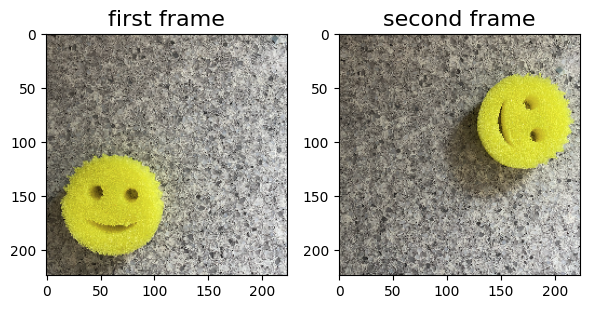

In [31]:
# create demo movie
%matplotlib inline
from cwm.vis_utils import imshow
demo_images_dir = '../../CounterfactualWorldModels/demo/images/'

img1_name = 'sponge_0.png'
img2_name = 'sponge_1.png'
img1 = Image.open(os.path.join(demo_images_dir, img1_name))
img2 = Image.open(os.path.join(demo_images_dir, img2_name))

tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224], interpolation=transforms.InterpolationMode.BICUBIC),
])

x = torch.stack([tr(_img)[0:3] for _img in (img1, img2)], 0)[None].to(DEVICE)
print("input shape: %s" % list(x.shape))

fig, axes = plt.subplots(1,2,figsize=(6,3))
imshow(x, t=0, ax=axes[0], title='first frame', fontsize=16)
imshow(x, t=1, ax=axes[1], title='second frame', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


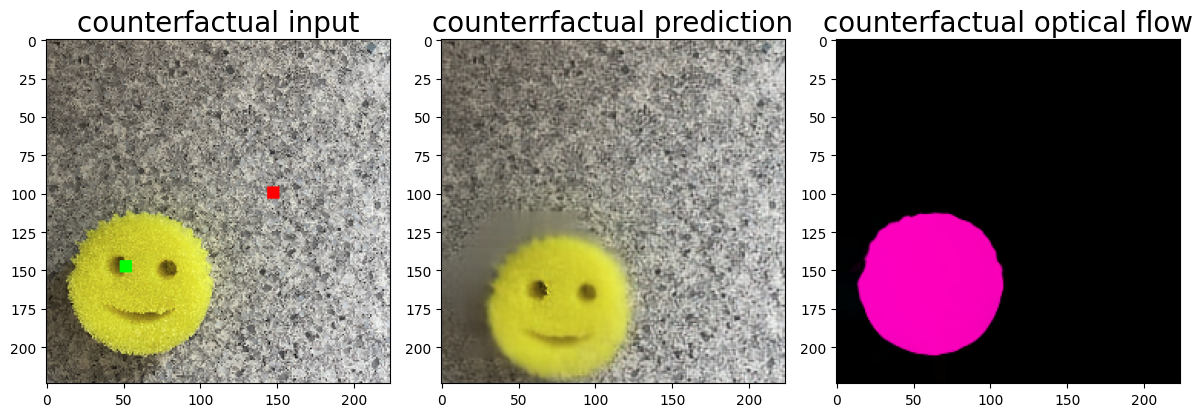

In [32]:
%matplotlib inline
'''
Counterfactual predictions are made by calling
   y_cf = Psi.get_counterfactual_prediction(x, mask, active_patches, shift)
   
   where 
      - x is the image input; if a movie, first frame used
      - active_patches are the patches to be moved
      - mask are the patches to be kept static
      - shift is a 2-list of the motion counterfactual direction (in patch widths)
'''

shift = [2, 2]
active_locs = [ [150, 50] ]
passive_locs = [ [100, 150] ]

Psi.set_input(x)
active_mask = Psi.generate_mask_from_patch_idx_list(active_locs)
passive_mask = Psi.generate_mask_from_patch_idx_list(passive_locs)

y_cf = Psi.get_counterfactual_prediction(x[:,0],
                                         mask=passive_mask,
                                         active_patches=active_mask,
                                         shift=shift,
                                         fix_passive=False # this will make sure only first frame of x is used
                                        )

x_cf = Psi.get_masked_pred_patches(
    Psi.make_static_movie(x[:,0:1], T=2),
    mask=active_mask, invert=False,
    fill_value=[0,1,0]
)
x_cf = Psi.get_masked_pred_patches(
    x_cf,
    mask=passive_mask, invert=False,
    fill_value=[1,0,0]
)
flow_cf = Psi.predict_flow(y_cf)

fig, axes = plt.subplots(1,3,figsize=(12,4))
imshow(x_cf[:,1], ax=axes[0], title='counterfactual input')
imshow(y_cf[:,1], ax=axes[1], title='counterrfactual prediction')
Psi.flowshow(flow_cf, ax=axes[2], title='counterfactual optical flow')

plt.tight_layout()
plt.show()                                        

### Look at flow and segments using interactive visualizer

In [11]:
def load_img(file_name, crop_size=None, size=[224, 224], device='cpu'):
    img = Image.open(file_name)
    img = np.array(img)
    tr = transforms.Compose([
        transforms.ToTensor(),
        (transforms.CenterCrop(crop_size) if crop_size is not None else torch.nn.Identity()),
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
    ])

    vid = torch.stack([tr(_img)[0:3] for _img in (img, img)], 0)[None].to(device)    
    return vid

In [27]:
# set this to some place you have e.g. images from your smartphone
demo_images_dir = '../../datasets/home_images/'
!ls $demo_images_dir

eggs.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x2901d3e50>, <Axes: >)

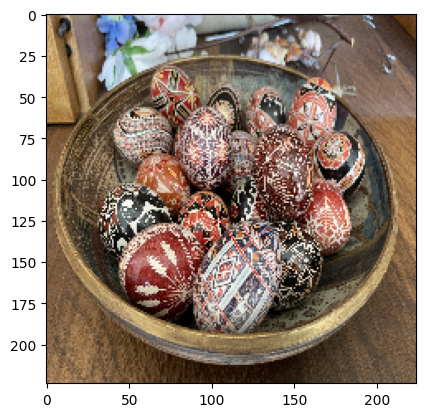

In [23]:
%matplotlib inline
x = load_img(os.path.join(demo_images_dir, 'eggs.png'), crop_size=None, device='mps')
imshow(x, t=0)

filtering by ['patch_magnitude', 'flow_area', 'num_corners']
using flow_magnitude_threshold 5.0
using flow_area_threshold 0.75
using num_corners_threshold 2

Create motion counterfactuals.

> click: place an active patch that will move by some integer number of patch widths
> right (or Command)-click: place a passive patch that will remain fixed in place
> CTRL or F-click: run the motion counterfactual with selected patches. Motion vector will be chosen randomly
> B-click: run S=sample_batch_size motion counterfactuals with random or preset_shifts directions
> hold-D and drag: set the direction of the motion counterfactual; active patches will change color to indicate this
> SHIFT-click: reset the chosen patches



<IPython.core.display.Javascript object>


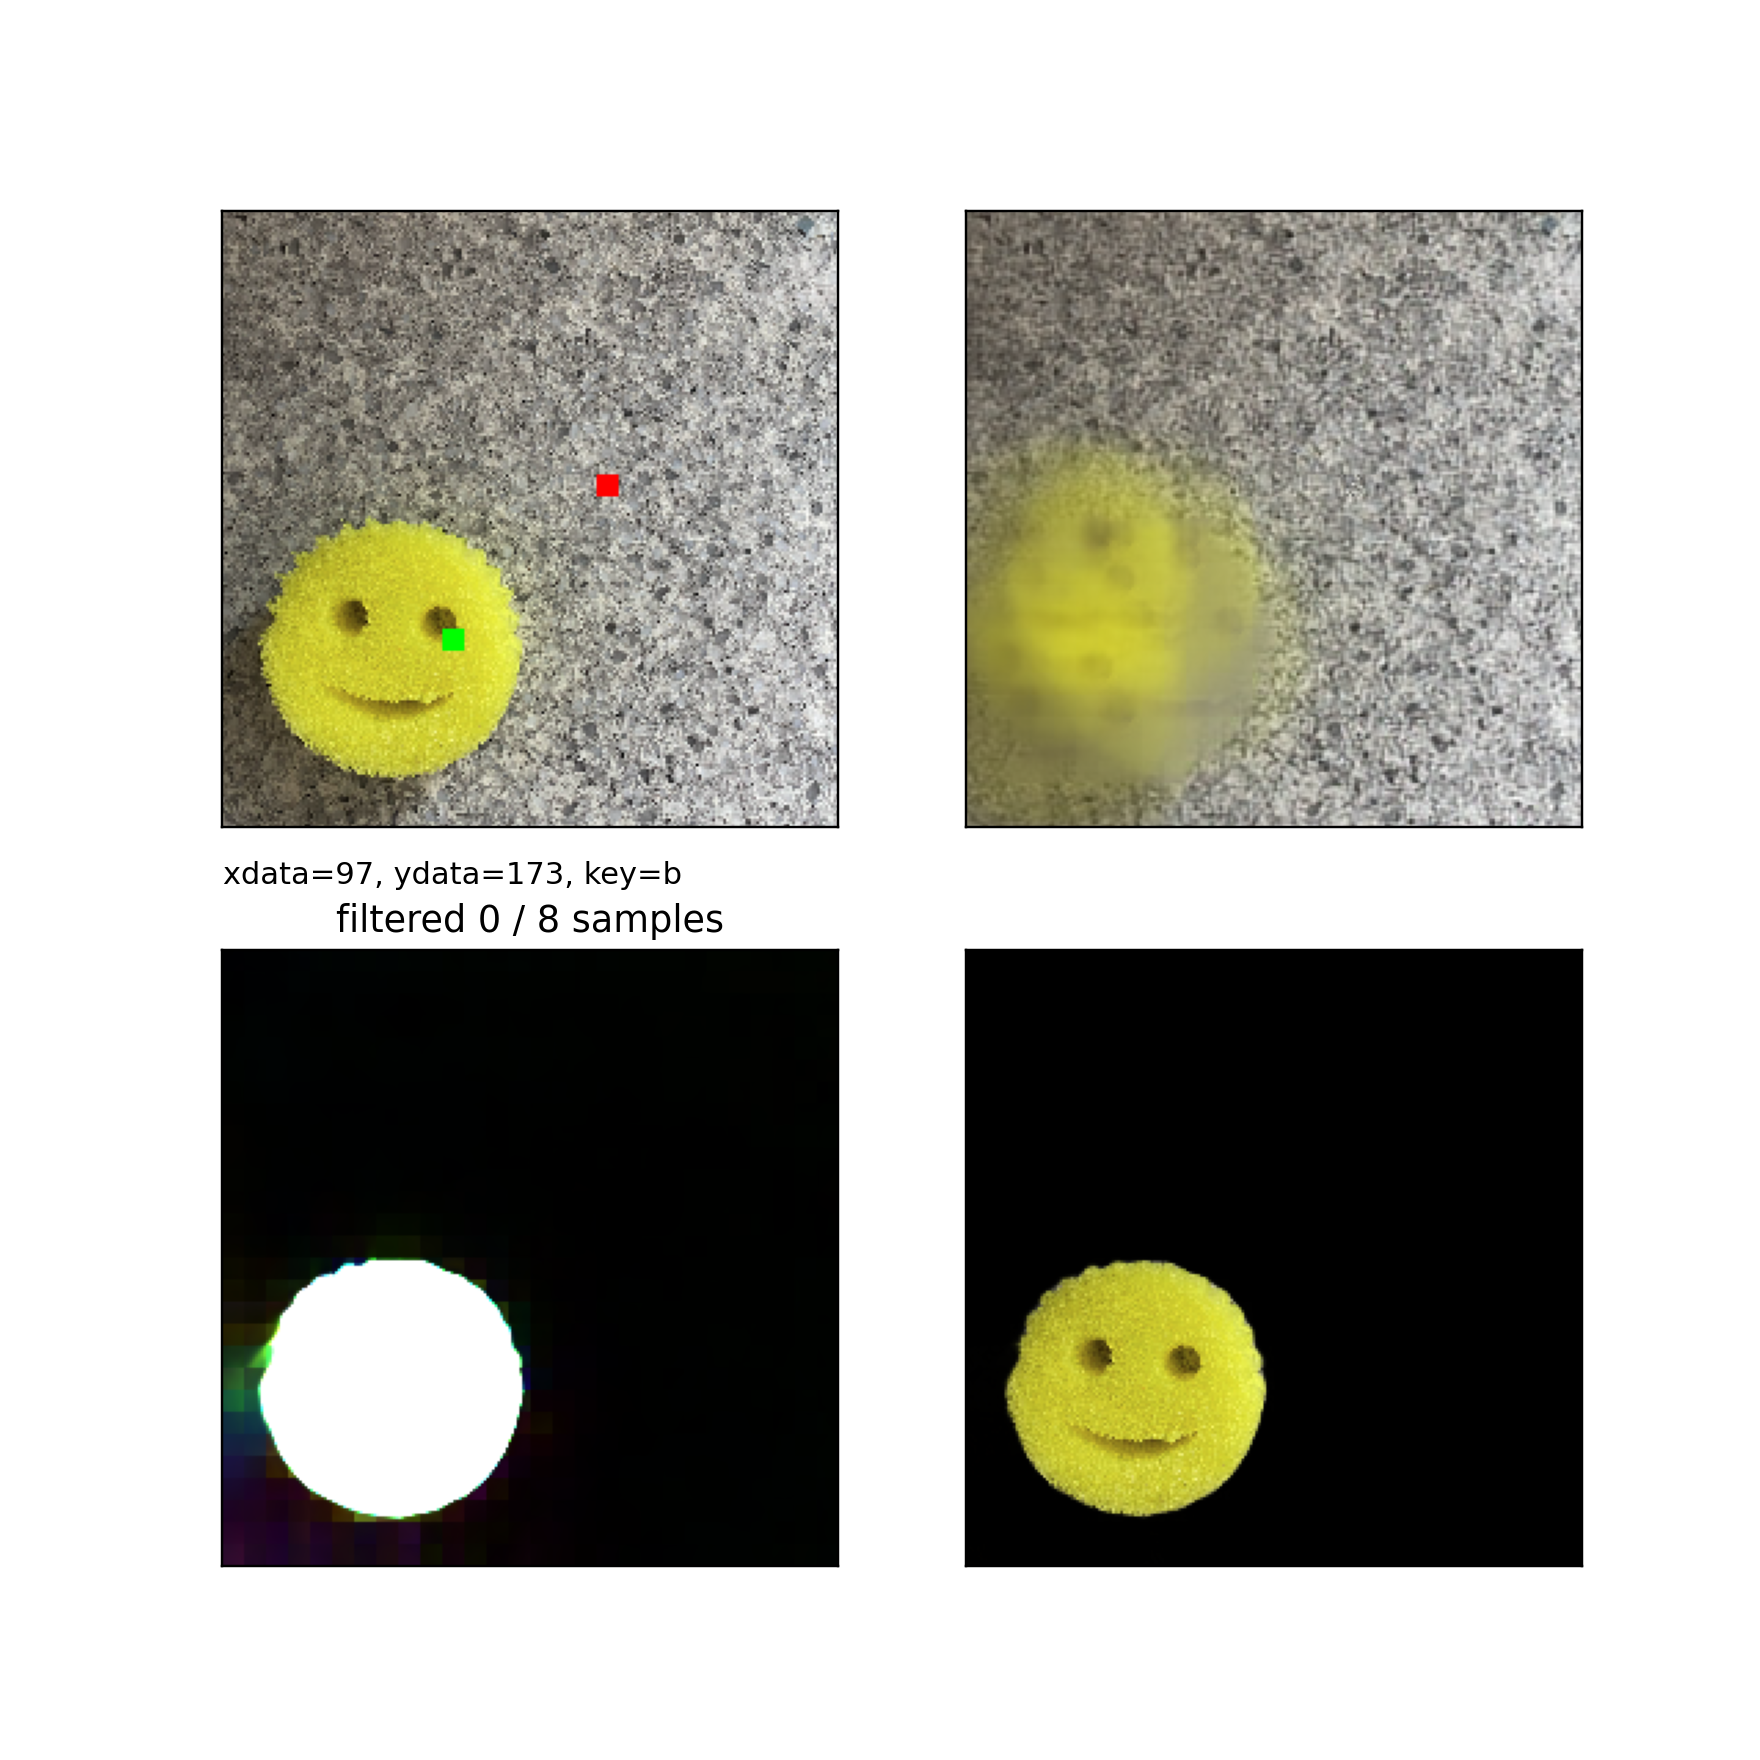

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [191]:
%matplotlib notebook
import cwm.interface as interface

## can filter flow samples based on certain criteria
## if filter_params is None, no filtering will occur
filter_params = {
    'filter_methods': ['patch_magnitude', 'flow_area', 'num_corners'],
    'flow_magnitude_threshold': 5.0,
    'flow_area_threshold': 0.75,
    'num_corners_threshold': 2
}
# filter_params = None

Psi.set_flow_sample_filter(filter_params)
print(Psi.flow_sample_filter)

docstr = '''
Create motion counterfactuals.

> click: place an active patch that will move by some integer number of patch widths
> right (or Command)-click: place a passive patch that will remain fixed in place
> CTRL or F-click: run the motion counterfactual with selected patches. Motion vector will be chosen randomly
> B-click: run S=sample_batch_size motion counterfactuals with random or preset_shifts directions
> hold-D and drag: set the direction of the motion counterfactual; active patches will change color to indicate this
> SHIFT-click: reset the chosen patches
'''

print(docstr)

# preset_shifts = [[2, 0], [0, 2], [-2, 0], [0, -2]]
preset_shifts = None

fig, axes = plt.subplots(2, 2, figsize=(8,8))
I = interface.CounterfactualPredictionInterface(
    axes=axes,
    G=Psi, # masked predictor wrapper with a method for predictinf flow
    x=x, # your image
    device=x.device, # where to run it
    active_color=[0, 1, 0], # what color to show active patches as when motion counterfactual direction is unset
    passive_color=[1, 0, 0], # what color to show passive (static) patches as
    preset_shifts=preset_shifts, # to run a particular set of directional motion counterfactuals, pass as a list
    max_shift=3, # maximum number of patch widths to make motion counterfactuals with
    show_ticks=False,
    sample_batch_size=8, # how many motion counterfactual samples to run when pressing 'B'
    max_samples_per_batch=4 # batch size for motion motion counterfactuals
)



### Multiple motion counterfactuals in parallel

In [148]:
y_mc, flow_mc = Psi.predict_counterfactual_videos_and_flows(
    x,
    active_patches=active_mask,
    passive_patches=passive_mask,
    shifts=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    num_samples=8,
    sample_batch_size=4
)


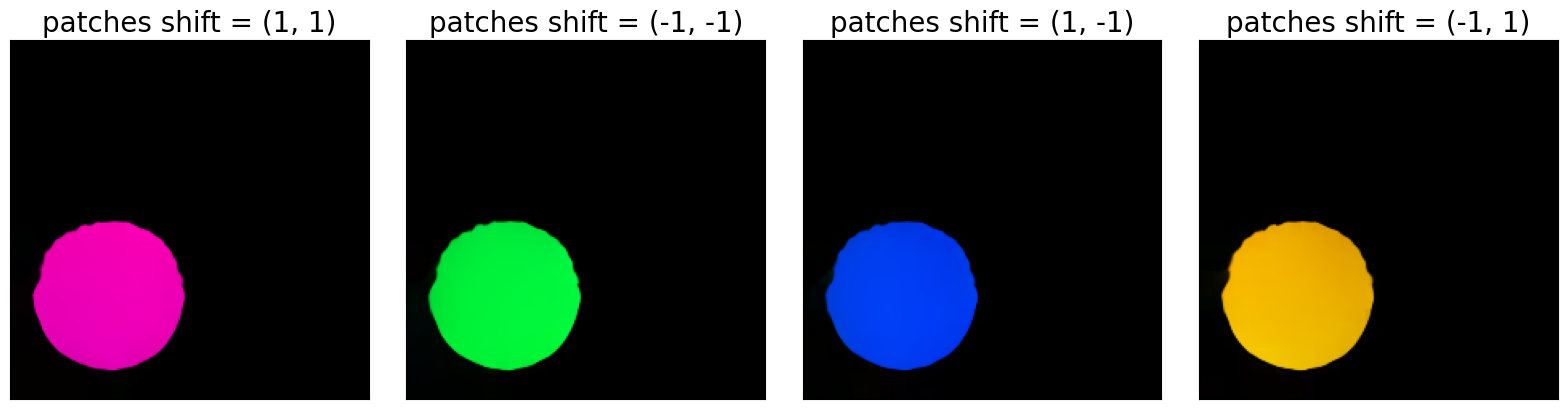

In [151]:
%matplotlib inline
fig, axes = plt.subplots(1,4,figsize=(16,4))
for i, ax in enumerate(axes):
    Psi.flowshow(flow_mc[i], set_max_speed=(i == 0), ax=ax, 
                 title="patches shift = (%d, %d)" % (Psi.shifts[i][0], Psi.shifts[i][1]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Load a head motion (IMU)-conditioned model

Using a masked predictor that has been trained on head motion allows better control over counterfactuals.

That's because we can pass in an input that says, e.g., "there is no camera motion in this scene."

In this case, it's less likely the counterfactual prediction will have motion due to camera panning,
and it will be easier to detect object motion.

In [279]:
## Download weights for model that predicts IMU from two frames (and optical flow) and the IMU-conditioned predictor
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
base_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/'
flow2imu_url = base_url + 'flow2imu_conjVMAE_224px.pth'
psiH_4x4base_url = base_url + 'cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth' 

!wget -nc --show-progress -P $model_checkpoint_dir $flow2imu_url
!wget -nc --show-progress -P $model_checkpoint_dir $psiH_4x4base_url

--2023-06-12 15:01:43--  https://counterfactual-world-modeling.s3.amazonaws.com/flow2imu_conjVMAE_224px.pth
Resolving counterfactual-world-modeling.s3.amazonaws.com (counterfactual-world-modeling.s3.amazonaws.com)... 52.217.111.44, 54.231.200.209, 52.216.53.137, ...
Connecting to counterfactual-world-modeling.s3.amazonaws.com (counterfactual-world-modeling.s3.amazonaws.com)|52.217.111.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1641966969 (1.5G) [binary/octet-stream]
Saving to: ‘../../CounterfactualWorldModels/checkpoints/flow2imu_conjVMAE_224px.pth’

flow2imu_conjVMAE_2 100%[===================>]   1.53G  17.4MB/s    in 93s     

2023-06-12 15:03:17 (16.8 MB/s) - ‘../../CounterfactualWorldModels/checkpoints/flow2imu_conjVMAE_224px.pth’ saved [1641966969/1641966969]

--2023-06-12 15:03:17--  https://counterfactual-world-modeling.s3.amazonaws.com/cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth
Resolving counterfactual-world-modeling.s3.amazonaws.com (c

In [244]:
import cwm.models.VideoMAE.conjoined_vmae as conj

padded_model = conj.PaddedVisionTransformer(img_size=224,
                                            num_frames=2,
                                            tubelet_size=1,
                                            min_padding_tokens=0,
                                            patch_size=(8, 8)).to(DEVICE)
                                            
# the wrapper for making predictions
PsiP = segmentation.FlowGenerator(
        predictor=padded_model, # the model function with loaded weights
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator, # a way of generating masks automatically if desired
        seed=0,
        flow_model=raft # set RAFT to easily evaluate flow
).requires_grad_(False).to(DEVICE)

NUM PATCHES IN ENCODER 1568
No predictor weights were loaded in constructing the FlowGenerator
This is fine as long as you already loaded the weights!
set RAFT to 24 iters


In [246]:
PsiP.predictor.PRINT_PADDING = False
mask_generator.num_visible = 8
m1 = mask_generator()
mask_generator.num_visible = 8
m2 = mask_generator()

m = torch.cat([m1, m2], 0).to(x.device)
print(m.sum(-1))
_x = torch.cat([x, x], 0)

y = PsiP(_x, m)
print(y.shape)

tensor([776, 776], device='mps:0')
torch.Size([2, 2, 3, 224, 224])


In [281]:
!ls ../checkpoints/

cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth
cwm_baseVMAE_224px_8x8patches_2frames.pth
cwm_largeVMAE_224px_4x4patches_2frames.pth
flow2imu_conjVMAE_224px.pth
raft_checkpoints


In [286]:
flow2imu_model = conj.imu400_8x8patch_2frames_1tube_flowbackrgb01()
did_load = flow2imu_model.load_state_dict(
    torch.load('../checkpoints/flow2imu_conjVMAE_224px.pth', map_location='cpu')['model'],
    strict=False)
print(did_load)


<All keys matched successfully> RAFT ../checkpoints/raft_checkpoints/raft-large.pth
NUM PATCHES IN ENCODER 784
NUM PATCHES IN ENCODER 25
1 main frames: [0, 1]
0 context frames: None
2 total frames
Parameter Breakdown:
Main stream: 92956480
Context stream: 23272512
Conjoining: 19501056
Total: 135730048
<All keys matched successfully>


In [289]:
imu_conditioned_model = conj.imu400_base_4x4patch_2frames_1tube()
did_load = imu_conditioned_model.load_state_dict(
    torch.load('../checkpoints/cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth', map_location='cpu')['model'],
    strict=False)
print(did_load)

NUM PATCHES IN ENCODER 6272
NUM PATCHES IN ENCODER 25
2 main frames: [0, 1]
0 context frames: None
2 total frames
Parameter Breakdown:
Main stream: 92496432
Context stream: 23272992
Conjoining: 32495616
Total: 148265040
<All keys matched successfully>
